## Collinearity analysis
### Author: Deb Debnath

#### Data loading

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from src.classifier import z_score, linear_classifier_score, linear_classifier_subscores, antilogit_classifier_score

In [4]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [5]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [6]:
mean_TPM = 10

In [7]:
num_patients = 243

In [8]:
seed = 321

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [11]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [12]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_21564/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [13]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [14]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [15]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [16]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [17]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [18]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [19]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

In [20]:
def calculate_vif(X: pd.DataFrame):
    """
    Calculates VIF for each feature in X.
    
    Args:
        X (pd.DataFrame): DataFrame of predictor variables.
    
    Returns:
        pd.DataFrame: DataFrame with variables and their VIF values.
    """
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [21]:
vif_values = calculate_vif(z_scores_df.T)
print(vif_values)

               Variable           VIF
0    ENSG00000079482.12  2.055804e+06
1     ENSG00000169021.5  6.683390e+05
2    ENSG00000204160.11  6.964089e+05
3     ENSG00000106780.8  5.693037e+05
4     ENSG00000163162.8  5.592856e+05
..                  ...           ...
650  ENSG00000105327.15  1.704804e+06
651  ENSG00000044115.20  1.980897e+06
652  ENSG00000065978.17  1.957595e+06
653  ENSG00000157734.13  1.614300e+06
654  ENSG00000116688.16  8.332737e+05

[655 rows x 2 columns]


<Axes: >

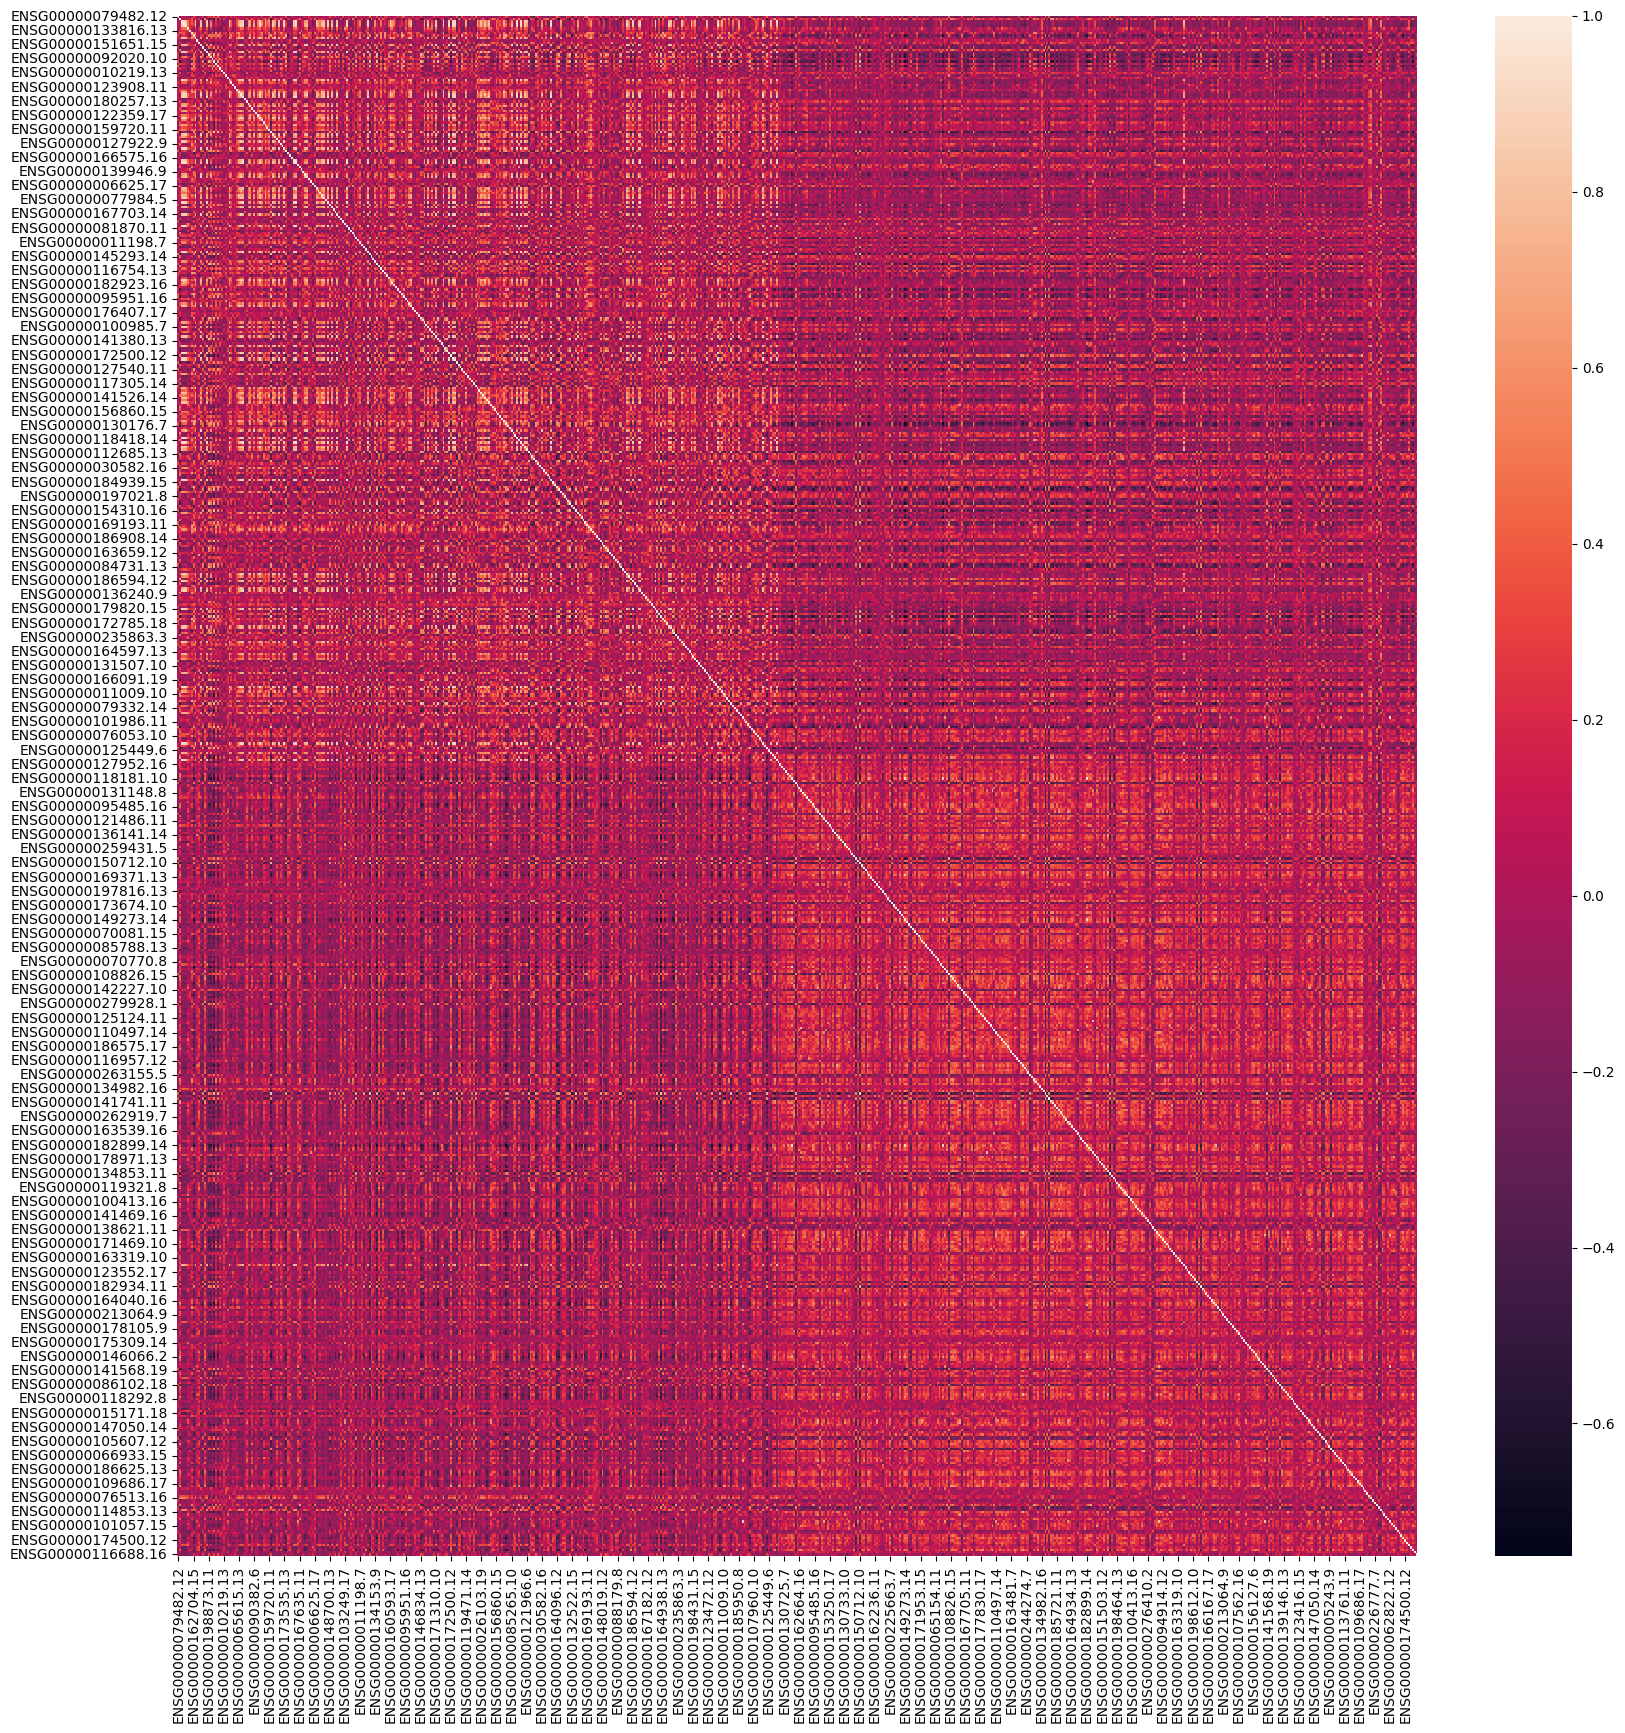

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(z_scores_df.T.corr())